In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import statistics
from sklearn.metrics import log_loss
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


Read file into r and transforming it

In [2]:
#Open the file
X_df = pd.read_csv(r"/Users/Kalide/Documents/Northeastern/Supervised Machine Learning Theory/Project/application_record.csv")


In [3]:
#Open the file
Y_df = pd.read_csv(r"/Users/Kalide/Documents/Northeastern/Supervised Machine Learning Theory/Project/credit_record.csv")

Check for NA's in the Dataset and 

In [4]:
print(X_df.isna().sum().sum())
print(Y_df.isna().sum().sum())

134203
0


In [5]:
#Removing Na's in dataset
X_df=X_df.dropna()

Create Dependent Variable

In [6]:
# find all users' account open month.
begin_month=pd.DataFrame(Y_df.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 
new_data=pd.merge(Y_df,begin_month,how="left",on="ID") #merge to record data

In [7]:
pd.options.mode.chained_assignment = None
Y_df['out'] = None
Y_df['out'][Y_df['STATUS'] =='2']='Yes' 
Y_df['out'][Y_df['STATUS'] =='3']='Yes' 
Y_df['out'][Y_df['STATUS'] =='4']='Yes' 
Y_df['out'][Y_df['STATUS'] =='5']='Yes'

In [8]:
cpunt=Y_df.groupby('ID').count()
cpunt['out'][cpunt['out'] > 0]='Yes' 
cpunt['out'][cpunt['out'] == 0]='No' 
cpunt = cpunt[['out']]
new_data=pd.merge(new_data,cpunt,how='inner',on='ID')
new_data['risk']=new_data['out']
new_data.loc[new_data['risk']=='Yes','risk']=1
new_data.loc[new_data['risk']=='No','risk']=0

Printing values for Variables

In [9]:
print(cpunt['out'].value_counts())
cpunt['out'].value_counts(normalize=True)

No     45318
Yes      667
Name: out, dtype: int64


No     0.985495
Yes    0.014505
Name: out, dtype: float64

Reanming X columns

In [10]:
X_df = X_df.rename(columns= {'CODE_GENDER':'Gender', 'FLAG_OWN_CAR':'Owns_car',
    'FLAG_OWN_REALTY':'Owns_property', 'CNT_CHILDREN':'Num_of_children', 'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment_status', 'NAME_EDUCATION_TYPE':'Education_level', 'NAME_FAMILY_STATUS':'Marital_status',
    'NAME_HOUSING_TYPE':'Housing', 'DAYS_BIRTH':'Age_in_days', 'DAYS_EMPLOYED': 'Length_of_employment_in_days',
    'FLAG_MOBIL': 'Owns_mobilephone', 'FLAG_WORK_PHONE': 'Work_phone', 'FLAG_PHONE': 'Owns_phone',
    'FLAG_EMAIL': 'Has_email', 'OCCUPATION_TYPE': 'Job_title', 'CNT_FAM_MEMBERS': 'Size_of_family'})

Inner and Create Test and Training Set

In [11]:
df=pd.merge(new_data,X_df,on="ID")

In [12]:
df=df[['Gender','Owns_property','Work_phone','Age_in_days',
'Length_of_employment_in_days','Size_of_family','Housing','Education_level',
'Marital_status','Has_email','Owns_car','Income','risk']]


Convert Characters to Binary

In [13]:
df.Gender[df.Gender == 'M'] = 1
df.Gender[df.Gender == 'F'] = 0
df.Owns_property[df.Owns_property == 'Y'] = 1
df.Owns_property[df.Owns_property == 'N'] = 0
df.Owns_car[df.Owns_car == 'Y'] = 1
df.Owns_car[df.Owns_car == 'N'] = 0

In [14]:
df= pd.get_dummies(df, columns=['Housing'])

In [15]:
df= pd.get_dummies(df, columns=['Marital_status'])

In [16]:
df= pd.get_dummies(df, columns=['Education_level'])

EDA

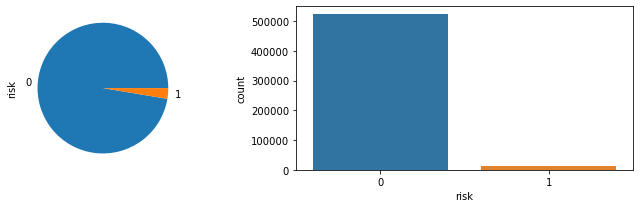

In [17]:
fig= plt.figure(figsize=(10,3) )
fig.add_subplot(1,2,1)
a= df["risk"].value_counts(normalize=True).plot.pie()
fig.add_subplot(1,2,2)
churnchart=sns.countplot(x=df["risk"])
plt.tight_layout()
plt.show()

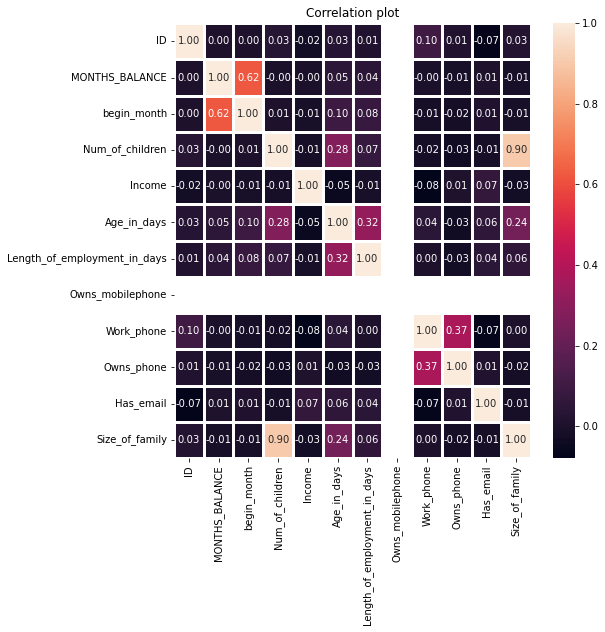

In [18]:
plt.figure(figsize=(8,8))
corr_plot = sns.heatmap((pd.merge(new_data,X_df,on="ID")).corr(),annot = True,linewidths=3,fmt='.2f')
plt.title("Correlation plot")
plt.show()

In [ ]:
ax = sns.histplot(df["Length_of_employment_in_days"].abs()/365)
ax.set_xlabel( "Length of employment in years" , size = 12 )

In [ ]:
ax1 = sns.histplot(np.log2(df["Income"]))
ax1.set_xlabel( "Log2Income" , size = 12 )

In [ ]:
ax = sns.boxplot(data=df[["Size_of_family"]], orient="h", palette="Set2")

In [ ]:
ax = sns.countplot(x="risk", data=df)

In [ ]:
ax = sns.boxplot(data=df[["Length_of_employment_in_days"]].abs()/365, orient="h", palette="Set3")
ax.set(yticklabels=[])
ax.set_ylabel( "Length of employment in years" , size = 12 )

In [ ]:
ax = sns.boxplot(data=df[["Age_in_days"]].abs()/365, orient="h", palette="Set3")
ax.set(yticklabels=[])
ax.set_ylabel( "Age in years" , size = 12 )

In [19]:
df_train = df.sample(frac=0.8, random_state=25)
df_test = df.drop(df_train.index)

Performing SMOTE to Fix Imbalanced Data

In [20]:
Y_train=df_train["risk"]
Y_train=Y_train.astype('int')
X_train=df_train[['Gender','Owns_property','Work_phone','Age_in_days',
'Length_of_employment_in_days','Size_of_family','Has_email','Owns_car','Income',
'Housing_Co-op apartment','Housing_House / apartment','Housing_Municipal apartment',
 'Housing_Office apartment','Housing_Rented apartment','Housing_With parents','Marital_status_Civil marriage',
 'Marital_status_Married','Marital_status_Separated','Marital_status_Single / not married','Marital_status_Widow',
 'Education_level_Academic degree','Education_level_Higher education','Education_level_Incomplete higher',
 'Education_level_Lower secondary','Education_level_Secondary / secondary special']]
scale=StandardScaler()
X_train=scale.fit_transform(X_train)
sm = SMOTE()
X_train, Y_train = sm.fit_resample(X_train, Y_train)

In [21]:
Y_test=df_test["risk"]
Y_test=Y_test.astype('int')
X_test=df_test[['Gender','Owns_property','Work_phone','Age_in_days',
'Length_of_employment_in_days','Size_of_family','Has_email','Owns_car','Income',
'Housing_Co-op apartment','Housing_House / apartment','Housing_Municipal apartment',
 'Housing_Office apartment','Housing_Rented apartment','Housing_With parents','Marital_status_Civil marriage',
 'Marital_status_Married','Marital_status_Separated','Marital_status_Single / not married','Marital_status_Widow',
 'Education_level_Academic degree','Education_level_Higher education','Education_level_Incomplete higher',
 'Education_level_Lower secondary','Education_level_Secondary / secondary special']]
X_test=scale.fit_transform(X_test)


Logistic Regression

In [22]:
model=LogisticRegression()


In [23]:
model.fit(X_train,Y_train)
y_predict = model.predict(X_test)

Accuracy:  0.5679279848976593
f1 score:  0.06500040247927232


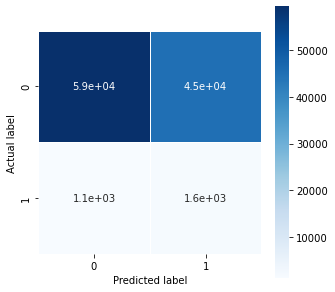

In [24]:
cm = confusion_matrix(Y_test, y_predict)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Accuracy: ",accuracy_score(y_predict, Y_test))
print("f1 score: ",f1_score(y_predict, Y_test))

Random Forest

In [25]:
model1=RandomForestClassifier()

In [26]:
model1.fit(X_train,Y_train)
y_predict1 = model1.predict(X_test)

Accuracy:  0.9676006435233835
f1 score:  0.6113342257920572


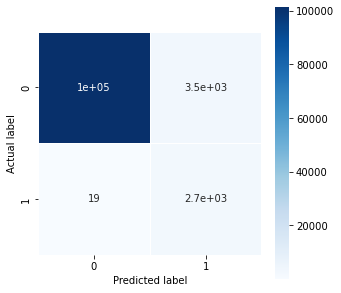

In [27]:
cm = confusion_matrix(Y_test, y_predict1)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Accuracy: ",accuracy_score(y_predict1, Y_test))
print("f1 score: ",f1_score(y_predict1, Y_test))

Adaboost

In [28]:
model2=AdaBoostClassifier()
model2.fit(X_train,Y_train)
y_predict2 = model2.predict(X_test)

Accuracy:  0.6725191336612947
f1 score:  0.09535797775323039


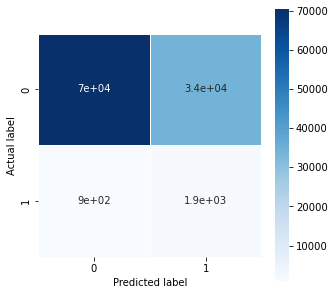

In [29]:
cm = confusion_matrix(Y_test, y_predict2)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Accuracy: ",accuracy_score(y_predict2, Y_test))
print("f1 score: ",f1_score(y_predict2, Y_test))

Naive Bayes

In [30]:
model3=GaussianNB()
model3.fit(X_train,Y_train)
y_predict3 = model3.predict(X_test)

Accuracy:  0.9734686096361117
f1 score:  0.006269592476489029


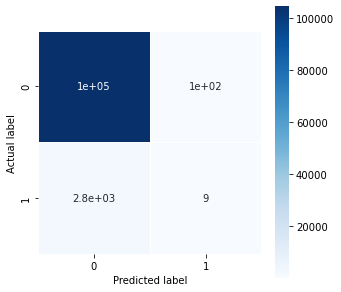

In [31]:
cm = confusion_matrix(Y_test, y_predict3)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Accuracy: ",accuracy_score(y_predict3, Y_test))
print("f1 score: ",f1_score(y_predict3, Y_test))

Hyperparameter Tuning of Logistic Regression

In [ ]:
solver = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['none', 'l1', 'l2', 'elasticnet']
C = [00.1,0.1, 0.5, 1,10,15]
grid = dict(penalty=penalty,C=C,solver=solver,)
grid_search = GridSearchCV(estimator=model, param_grid=grid,scoring='f1')
model4= grid_search.fit(X_train, Y_train)
y_predict4=model4.predict(X_test)

In [54]:
print(model4.best_estimator_)

LogisticRegression(C=0.1, solver='newton-cg')


Accuracy:  0.5679279848976593
f1 score:  0.06500040247927232


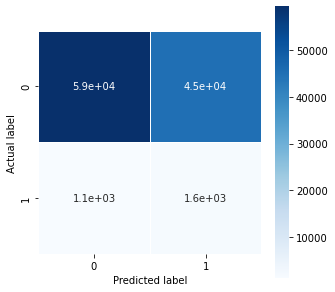

In [55]:
cm = confusion_matrix(Y_test, y_predict4)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Accuracy: ",accuracy_score(y_predict4, Y_test))
print("f1 score: ",f1_score(y_predict4, Y_test))

Hyperparameter Tuning for RandomForest

In [46]:
grid1 = {
    'n_estimators': [20,50,100,200]
}

grid_search1 = GridSearchCV(estimator=model1, param_grid=grid1,scoring='f1')
model5= grid_search1.fit(X_train, Y_train)
y_predict5=model5.predict(X_test)

In [65]:
print(model5.best_estimator_)

RandomForestClassifier()


Feature Importance

Accuracy:  0.9676285419359638
f1 score:  0.6118853829858402


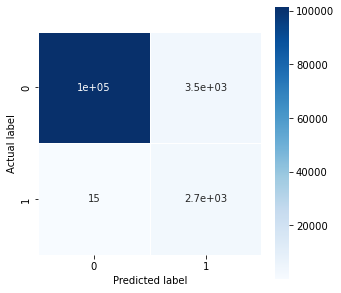

In [48]:
cm = confusion_matrix(Y_test, y_predict5)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Accuracy: ",accuracy_score(y_predict5, Y_test))
print("f1 score: ",f1_score(y_predict5, Y_test))

Hyperparameter Tuning for AdaBoost

In [40]:
grid2 = {
    "n_estimators": [50,100],
    'learning_rate':[0.001,0.1,1]
}
grid_search2 = GridSearchCV(estimator=model2, param_grid=grid2,scoring='f1')
model6= grid_search2.fit(X_train, Y_train)
y_predict6=model6.predict(X_test)

In [41]:
print(model6.best_estimator_)

AdaBoostClassifier(learning_rate=1, n_estimators=100)


Accuracy:  0.6934708415091181
f1 score:  0.10361144348961165


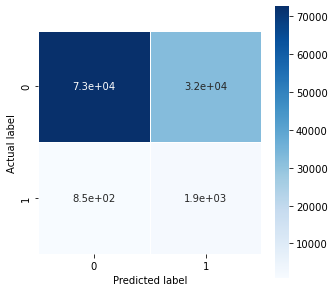

In [42]:
cm = confusion_matrix(Y_test, y_predict6)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Accuracy: ",accuracy_score(y_predict6, Y_test))
print("f1 score: ",f1_score(y_predict6, Y_test))

Hyperparameter Tuning for Naive Bayes

In [43]:
grid3 = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
grid_search3 = GridSearchCV(estimator=model3, param_grid=grid3,scoring='f1')
model7= grid_search3.fit(X_train, Y_train)
y_predict7=model7.predict(X_test)

In [44]:
print(model7.best_estimator_)

GaussianNB(var_smoothing=1.519911082952933e-07)


Accuracy:  0.07208949810755769
f1 score:  0.0516646549511961


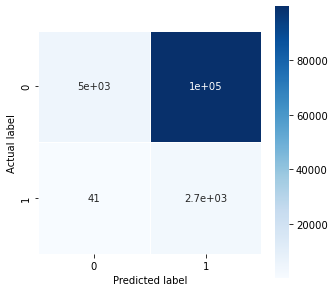

In [45]:
cm = confusion_matrix(Y_test, y_predict7)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Accuracy: ",accuracy_score(y_predict7, Y_test))
print("f1 score: ",f1_score(y_predict7, Y_test))